### Simple Sentiment Analysis

Using comments from a 2017 UITS satisfaction survey, we will create plots to analyze the sentiment of faculty, staff, graduate students, and undergraduate students from multiple campuses.

### Global parameters 

You will need to have set up a [Karst account](https://kb.iu.edu/d/bezu#account) first. Once you have your Karst account simply go to [rstudio.iu.edu](https://rstudio.iu.edu/auth-sign-in) and login using your IU username and passphrase.  Next, set the working directory by pointing to the location on Karst where you have stored the files. Below, we have chosen to save the folder "Text-Analysis" as a "Project" in R Studio on the Karst super-computer here at Indiana University. It contains the R scripts, texts, notebooks, and results. If you have forked and cloned the Github repository (see [textPrep.Rmd](textPrep.Rmd) for directions on how), simply point to where you have saved the folder. If you save it to your personal Karst folder, it will most likely look very similar to the example below. Karst is a unix server and so the home directory is represented by a ~ and, thus, the path will look like this "~/Text-Analysis/" (with the quotes). Alternatively, if you are on a PC, you will need to use an absolute path such as "C:/Users/XXX" (with the quotes again).

In R Studio, click Session in the menu bar > Set Working Directory > Choose Directory, then select the Text-Analysis directory in which you are working. This will set your working directory in the console pane, but make sure to copy the path into the source pane above to keep the directory constant if you close this script and reopen later. Make sure you click on the blue cube with a "R" in the center to set your working directory to your Text-Analysis project path.

HINT: Your working directory is the folder from which you will be pulling your texts.

In [1]:
setwd("~/Text-Analysis/")

### Include necessary packages for notebook 

R's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of R, others created by R users are available for download. Make sure to have the following packages installed before beginning so that they can be accessed while running the scripts.

In R Studio, packages can be installed by navigating to Tools in the menu bar > Install Packages. Or in the bottom right panel click on the "packages" tab and then click on "install."

These five packages are used within the sentiment analysis script:

- **tm:** A package for text mining

- **plyr:** this package splits, combines, and applies data (the laply function used below while instantiating the algorithm comes with this package)

- **stringr:** eases string operations (we will use str_split also while instantiating the algorithm, which is included with the stringr package).

- **ggplot2:** a great package that renders a range of plots to display information, we will use this package to create our ultimate plots

In [3]:
library(tm)
library(plyr)
library(stringr)
library(ggplot2)

### Load data 

Each .csv file is a curated set of comments. The comments orginially return as a list, which was then saved as the .csv files you see here. We load the .csv files into our environment using read.csv and save them into a variable we can use later. 

Hint 1: The names of the variables can be anything (happiness, rainbows, cats), but usually, you want to name them using terms to indicate what the variable holds. Here we use faculty.uits to represent the comments associated with faculty who took the survey, and so on for the others. The period (.) between "faculty" and "uits" does not serve any purpose other than to separate the two terms for ease of reading. 

Hint 2: Another popular naming convention is to list the type of object with the name, for example faculty.uits.l since this object is a list. This convention helps when manipulating the data later.

In [4]:
faculty.uits <- read.csv("data/survey/IUBfaculty.csv")
staff.uits <- read.csv("data/survey/IUBstaff.csv")
grad.uits <- read.csv("data/survey/IUBgrad.csv")
undergrad.uits <- read.csv("data/survey/IUBundergrad.csv")

### Inspect Data

Before preparing the data for analysis, let us first see what we are working with. For tutorial purposes, we will look at the first: faculty.uits, but feel free to use the same commands to inspect any of the variables we have created. This step is a good idea to ensure you know what you are ultimately analyzing. For example, if you find that the length is zero, you may have to go back and reload or re-grab the data.

Class describes the type of object. In this case, we have a .csv file, which results in a data frame:

In [5]:
class(faculty.uits)

[1] "data.frame"

Length shows how many elements the object has. We had 45 comments, so our data frame is made up of 1 element. An element here is a column!

In [6]:
length(faculty.uits)

[1] 1

Perhaps you would like to see the first few comments:

In [7]:
head(faculty.uits)

text
"By far the biggest problems I have experienced have been related to lack of knowledge of glitches in using Canvas, and Canvas in general."
"Canvas is not user friendly. Most of my time with UITS is about Canvas issues, but not all staff have a good understanding of the platform."
Contacting UITS by phone has been really useful on multiple occasions. I really appreciate being able to call them at any time.
"I'm not positive what role UITS plays in this, but the annual ballots that are sent to IUB faculty to nominate and vote for BFC members has this problem: One cannot go back to modify one's votes, even when one simply wants to go back and add more nominations/votes rather than to actually change one's existing nominations/votes."
I always appreciate quick responses from UITS staff members in a timely manner but it may be more convenient for us if the email can be forwarded to the appropriate department when the question was submitted to a department but should be better accommodated by other department.
"I am a visiting lecturer, teaching at Indiana University (Bloomington) for just the Spring semester of 2017. During this limited period I have had very limited experience with UITS, but the experience that I have had has been highly satisfying. I have contacted UITS staff on two occasions (had problems with projecting video material in class; a minor technical matter with posting on Canvas); both times staffers were nice and very helpful."


There are many more ways to inspect parts of data (check out the CRAN), but these quick checks are helpful while manipulating and trimming the data pre-analysis.

### Extract Text

Since since our data is in a .csv file it is a data frame. We need to extract the text and save it as another variable. For sentiment analysis, we just need the text. The following line extracts the text from each comment in the data frame and saves the new list of just text as [responder_status].text.

In [8]:
faculty.text = faculty.uits$text
staff.text = staff.uits$text
grad.text = grad.uits$text
undergrad.text = undergrad.uits$text

Now we are all set! Let's load in some postivity (and negativity, I guess...)!

### Loading the Opinion Lexicons to Determine Sentiment

This is an essential step for sentiment analysis. These text documents from Hu and Liu, 2004* are filled with positive and negative words, respectively. The algorithm we will write next will check these documents to score each word in the comment. If the algorithm runs across the word "love" in a comment, it will check the positive-words.txt file, find "love" is included, and score the word with a +1. More on that in a second...

In [9]:
lex.pos = scan('data/opinionLexicon/positive-words.txt', what='character', comment.char = ';')
lex.neg = scan('data/opinionLexicon/negative-words.txt', what='character', comment.char = ';')

Add words relevant to our corpus using the combine c() function and remove words that may skew the results creating a new variable and using removeWords and the combine c() function:

In [10]:
pos.words = lex.pos
neg.words = lex.neg
pos.words <- removeWords(pos.words, c('work', 'secure', 'support'))
neg.words <- removeWords(neg.words, c('issue', 'issues', 'problem', 'problems', 'cloud'))

### Implement the sentiment scoring algorithm

Here is where the magic happens - let's create the algorithm! To begin a function which will iterate over all of the elements in the specified object, we need to give it a name - score.sentiment sounds good. First, we set the name of our function equal to function(). Then, we fill the parenthesis with our arguments. Here, we want an argument for the comments (our data we gathered), our positive words, and our negative words. 

This function takes in an argument (comments for us), normalizes all of the text (including removing emojis, just in case), splits the comments into separate words to analyze, compares the comment words to the positive and negative dictionaries, returns a TRUE if the word is in the dictionary and FALSE if it is not, the trues and falses are summed up for each comment (this is the score of the comment), and finally, the comments's score and its text are returned as another data frame for ease of plotting.

Hint: You may notice some odd expressions in the first few lines of the scores function: they are called regular expressions (or, regex). Regular expressions allow the user to match on certain patterns throughout the entire text. In this case, we are matching on punctuation, control characters (or invisible, non-printing characters), and digits, in the effort to strip out unnecessary characters that do not provide sentiment valence. Check out [this CRAN page](https://stat.ethz.ch/R-manual/R-devel/library/base/html/regex.html) for more information about using regex in R.

In [11]:
score.sentiment = function(contents,pos.words, neg.words, .progress='none')
{
  
  #figure out the score for each tweet specifically
  scores = laply(contents, function(content, pos.words, neg.words) {
    #normalize tweet text
    content = gsub('[[:punct:]]', '', content)
    content = gsub('[[:cntrl:]]', '', content)
    content = gsub('\\d+', '', content)
    
    #REMOVE EMOJIS!
    content = iconv(content, "ASCII", "UTF-8", sub="")
    
    content.lower = tolower(content)
    
    #split list into separate words
    word.list = str_split(content.lower, '\\s+')
    words = unlist(word.list)
    
    #compare our words to the dictionaries of positive and negative terms using match function
    pos.matches = match(words, pos.words)
    neg.matches = match(words, neg.words)
    
    #match returns a position of the matched term or NA, but we just want the TRUE/FALSE, not NA
    pos.matches = !is.na(pos.matches)
    neg.matches = !is.na(neg.matches)
    
    #the score of each tweet is the sum of the positive matches minus the sum of the negative matches
    score = sum(pos.matches) - sum(neg.matches)
    
    return(score)
  }, pos.words, neg.words, .progress = .progress)
  
  #compile the scores and text of tweets into a data frame for plotting
  scores.df = data.frame(score=scores, text = contents)
  return(scores.df)
}

### Algorithm Testing

Whenever you create a function (or algorithm), it is best to test it on some sample data to ensure it behaves as you expect. Let's create a sample list of emotional sentences and save it as "sample".

In [12]:
sample = c("This ice cream is the best! I love this flavor!", 
           "I am so angry at the terrible weather today. Frustrated.", 
           "Wow, spectacular, I wish I could be as perfect as you.")

We already did the hard part by building our score.sentiment function earlier. Here, we just need to tell the algorithm what to use as arguments! We need to put our sample data in as the "content" argument, pos.words as the "pos.words"" argument, and neg.words as the "neg.words" argument! 

Lets also save the result of running the algorithm as an object called sample.result.

In [13]:
sample.result = score.sentiment(sample, pos.words, neg.words)

Did it work?

In [14]:
sample.result

score,text
2,This ice cream is the best! I love this flavor!
-3,I am so angry at the terrible weather today. Frustrated.
3,"Wow, spectacular, I wish I could be as perfect as you."


It worked! Now we can be sure our algorithm is behaving as we would expect. Lets score our survey data since we are confident in our function-creating abilities...

### Scoring Survey Data

Again, we have already created our function, we just need to tell it what to analyze. We will use our [status].text objects as the "contents" argument and save each as an object called [status].result to plot a little later.

In [15]:
faculty.result = score.sentiment(faculty.text, pos.words, neg.words)
staff.result = score.sentiment(staff.text, pos.words, neg.words)
grad.result = score.sentiment(grad.text, pos.words, neg.words)
undergrad.result = score.sentiment(undergrad.text, pos.words, neg.words)

Now we are going to add a column in each dataset named "group" and it is done by saying take the variable "faculty.result" and add the column ($) "group" and then add the word 'Faculty' to the cells in that column.

In [16]:
faculty.result$group = 'Faculty'
staff.result$group = 'Staff'
grad.result$group = 'Grad'
undergrad.result$group = 'Undergrad'

Lets peek at the results to see if it is still working...

In [17]:
head(faculty.result)

head(staff.result)

head(grad.result)

head(undergrad.result)

score,text,group
-2,"By far the biggest problems I have experienced have been related to lack of knowledge of glitches in using Canvas, and Canvas in general.",Faculty
2,"Canvas is not user friendly. Most of my time with UITS is about Canvas issues, but not all staff have a good understanding of the platform.",Faculty
2,Contacting UITS by phone has been really useful on multiple occasions. I really appreciate being able to call them at any time.,Faculty
1,"I'm not positive what role UITS plays in this, but the annual ballots that are sent to IUB faculty to nominate and vote for BFC members has this problem: One cannot go back to modify one's votes, even when one simply wants to go back and add more nominations/votes rather than to actually change one's existing nominations/votes.",Faculty
5,I always appreciate quick responses from UITS staff members in a timely manner but it may be more convenient for us if the email can be forwarded to the appropriate department when the question was submitted to a department but should be better accommodated by other department.,Faculty
1,"I am a visiting lecturer, teaching at Indiana University (Bloomington) for just the Spring semester of 2017. During this limited period I have had very limited experience with UITS, but the experience that I have had has been highly satisfying. I have contacted UITS staff on two occasions (had problems with projecting video material in class; a minor technical matter with posting on Canvas); both times staffers were nice and very helpful.",Faculty


score,text,group
0,I no longer receive info about the number of pages left on my printing quota; this was very helpful & I wish this service had not been discontinued.,Staff
-1,"Come to think of it, I have not received an e-newsletter from UITS recently either. Why was this discontinued?",Staff
0,"First floor Wells UITS staff service has improved greatly, but it is still uneven. Staff members should never tell patrons ""I don't know,"" but instead should try to find out something or point patrons in the direction of someone who does know. They should wear name badges to be held accountable.",Staff
1,Overall campus computer centers could be MUCH cleaner please.,Staff
0,School of Education library computers are a mess now that [IRD] (dedicated staff) are gone. They're always down. Please bring the service back to the level it was when the two of them were at IU!,Staff
1,I work on all campuses - Kokomo library computers are great and so is the helpdesk!,Staff


score,text,group
2,"All issues I have had they have told me are external vendor issues. I would say that either means they're doing a great job, or everything important is outsourced.",Grad
-4,"Brought my computer into UITS at Wells because it was slow, and a member of your staff downloaded software that my computer did not support and I was unable to get past the login screen for almost a week. Then took it back and a different member got me back up and running, but my computer was easily twice as slow as when I originally brought it in, it's borderline unusable now.",Grad
1,Please make sure your staff are more careful and knowledgeable.,Grad
0,Canvas has been having outages lately.,Grad
0,"Knowledge Base can be very confusing, but helpful if you keep digging for information.",Grad
3,"Canvas is clunky and doesn't allow me the freedom in grading that Oncourse did. I've been working with various IU systems for [IRD] years and it seems like each of these shifts add some new tools, but take away some very important ones. It would be great if we could give feedback before these big changes occur.",Grad


score,text,group
-1,"A couple weeks ago, I had a problem with a desktop computer located in Willkie center building. When I was working on an assignment due at midnight that night, the computer unexpectedly went into sleep mode and would not come out of it. It was 9:00 p.m. and I called UITS for help. They tried telling me a couple of things that I could do, all of which I tried with no success. That was understandable. However, they then told me there was nothing they could do to help me. I was very dissatisfied with the lack of care or information that I was given about how to further solve the problem.",Undergrad
-1,Absolutely dislike the two step login.,Undergrad
0,"Assistants at the UITS help desk at Wells are generally prompt and prepared. There could be improvement with wait-times and appointment sign-ups to increase efficiency. DUO has some problem-areas - it is recommended that DUO two-step authentication not be applied to all applications requiring IU login (for instance, applications that allow someone to report a stolen or lost ID should be able to bypass DUO authentication, as phones are often stolen at the same time as IDs, which means that individuals can't readily report their cards stolen).",Undergrad
1,Better Wi-Fi Connections.,Undergrad
0,Warnings to system shut downs.,Undergrad
-1,Canvas sucks.,Undergrad


Now we plot the data. We have to do a separate plot for each set of survey data since we want to view them separately based on Faculty, Staff, Graduate, and Undergraduate. Since all the plots do basically the same thing we will walk you through the plotting.
1. To begin, we need to adjust the width and height of the graph output or we end up getting a square shaped steamgraph which is hard to read.
2. Then we set an option that will only show us the first three places after the decimal point for any calculations.
3. Then we say we want the graphs to be plotted 2 x 2, so two graphs per row and per column.
4. Next we say we want a histogram of the score column, what color we want the histogram to be, what the limits of the y axis should be as well as the x axis, what the main title of the graph should say, what we want to label the x axis and y axis, that the x ticks should be sequential from one number to another (-17,17), and that we want to see the totals for each level of sentiment.
5. Now we set parameters for the x axis. We determine the style of the x ticks, where the ticks should be in relation to the bars, that the labels go from -16 to 17 and count by 1, and that the labels should by vertical, not horizontal.
6. Next we say we want to see the mean score and have it represented by a "purple" line at the mean location in the graph.
7. Next we say we want to mark the "zero" line and have it represented by a "black" line in the graph.
8. Now we calculate the mean and save it as a variable.
9. Next we calcualte the standard deviation and save it as a variable.
10. Now we determine how we want the mean and standard deviation labeled
11. Lastly, we create legend that shows what the bar and line colors indicate as well as the actual calculations for the mean and standard deviation.

These steps are done for all four graphs.

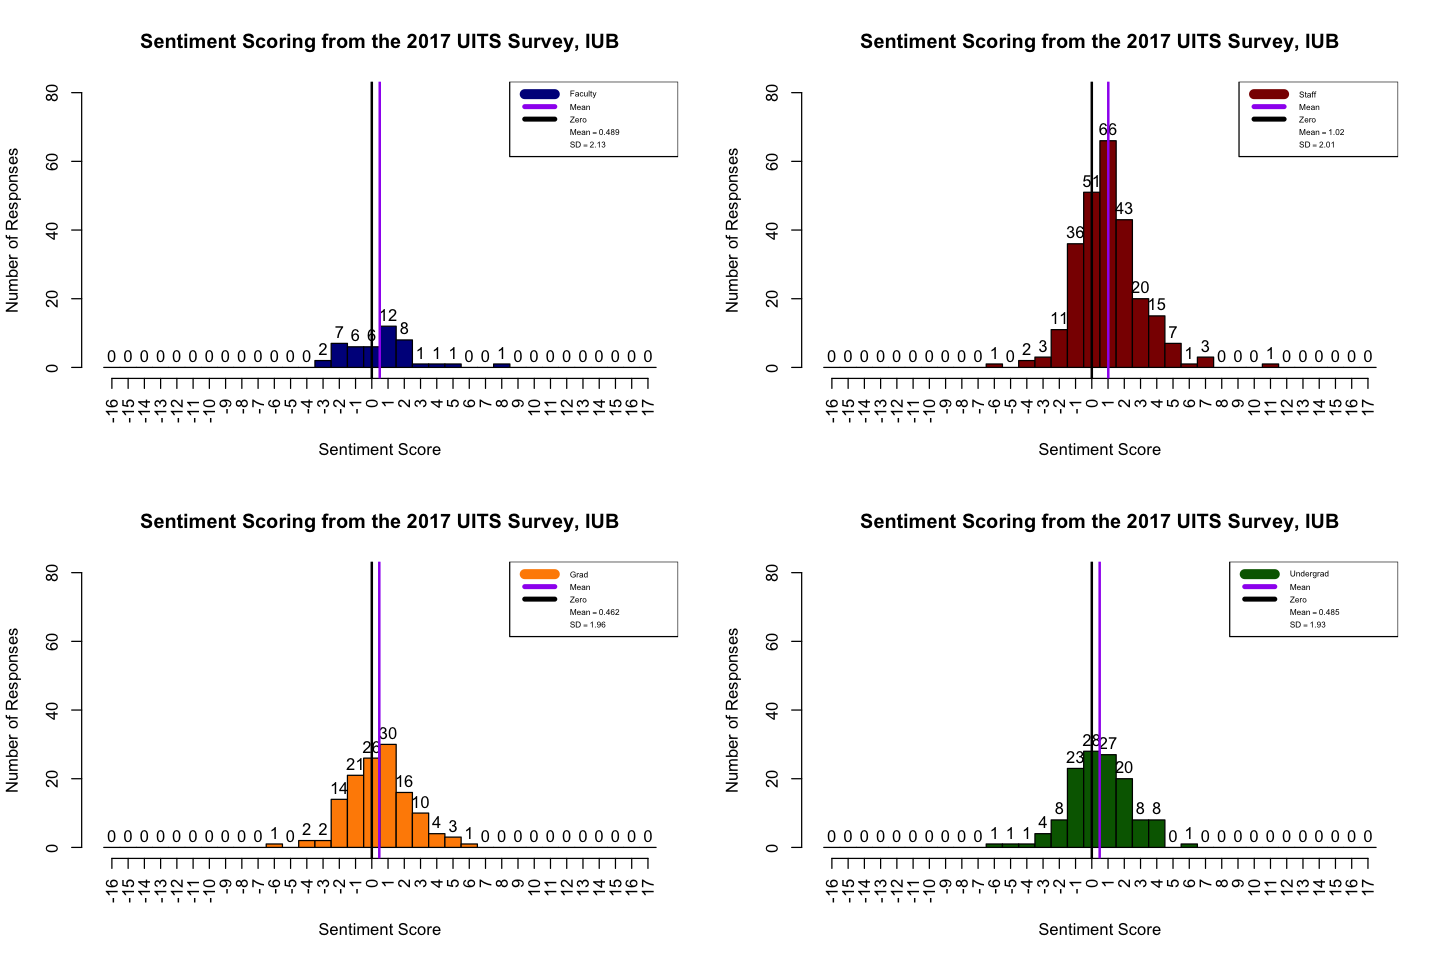

In [18]:
options(repr.plot.width=12, repr.plot.height=8)
options(digits=3)

par(mfrow=c(2,2))
p1 = hist(faculty.result$score, col = "darkblue", ylim = c(0,80),xlim=c(-17,17), 
                     main = "Sentiment Scoring from the 2017 UITS Survey, IUB", 
                     xlab= "Sentiment Score", ylab="Number of Responses", breaks = seq(-17,17),labels=TRUE,xaxt = 'n')
axis(side=1, at = p1$mids, labels = seq(-16,17,1), las = 2)
abline(v = mean(faculty.result$score)-.5, col = "purple", lwd = 2, untf = TRUE)
abline(v = 0-.5, col = "black", lwd = 2)
facMean <- mean(faculty.result$score)
facSD <- sd(faculty.result$score)
fa= list( bquote(Mean== .(facMean)), bquote(SD== .(facSD) ) )
legend("topright", c("Faculty", "Mean", "Zero", sapply(fa, as.expression)) , col = c("darkblue", "purple", "black", "white","white"), lwd=c(8, 4, 4,1,1), cex=.5, pt.cex=.5)
#legend('topleft', legend=sapply(fa, as.expression))

p2 = hist(staff.result$score, col = "darkred", ylim = c(0,80),xlim=c(-17,17),
                  main = "Sentiment Scoring from the 2017 UITS Survey, IUB",
                  xlab= "Sentiment Score", ylab="Number of Responses", breaks = seq(-17,17),labels=TRUE, xaxt = 'n')
axis(side=1, at=p2$mids, labels = seq(-16,17,1), las = 2)
abline(v = mean(staff.result$score)-.5, col = "purple", lwd = 2)
abline(v = 0-.5, col = "black", lwd = 2)
stfMean <- mean(staff.result$score)
stfSD <- sd(staff.result$score)
st= list( bquote(Mean== .(stfMean)), bquote(SD== .(stfSD) ) )
legend("topright", c("Staff", "Mean", "Zero", sapply(st, as.expression)) , col = c("darkred", "purple", "black", "white", "white"), lwd=c(8, 4, 4), cex=.5, pt.cex=.5)
#legend('topleft', legend=sapply(st, as.expression))

p3 = hist(grad.result$score, col = "darkorange", ylim =c(0,80),xlim=c(-17,17),
                    main = "Sentiment Scoring from the 2017 UITS Survey, IUB", 
                    xlab= "Sentiment Score", ylab="Number of Responses", breaks = seq(-17,17),labels=TRUE, xaxt = 'n')
axis(side=1, at=p3$mids, labels = seq(-16,17,1), las = 2)
abline(v = mean(grad.result$score)-.5, col = "purple", lwd = 2)
abline(v = 0-.5, col = "black", lwd = 2)
grdMean <- mean(grad.result$score)
grdSD <- sd(grad.result$score)
g= list( bquote(Mean== .(grdMean)), bquote(SD== .(grdSD) ) )
legend("topright", c("Grad", "Mean", "Zero", sapply(g, as.expression)) , col = c("darkorange", "purple", "black", "white", "white"), lwd=c(8, 4, 4), cex=.5, pt.cex=.5)
#legend('topleft', legend=sapply(g, as.expression))

p4 = hist(undergrad.result$score, col = "darkgreen", ylim = c(0,80),xlim=c(-17,17),
                   main = "Sentiment Scoring from the 2017 UITS Survey, IUB", 
                   xlab= "Sentiment Score", ylab="Number of Responses", breaks = seq(-17,17),labels=TRUE, xaxt = 'n')
axis(side=1, at=p4$mids, labels = seq(-16,17,1), las = 2)
abline(v = mean(undergrad.result$score)-.5, col = "purple", lwd = 2)
abline(v = 0-.5, col = "black", lwd = 2)
ugrdMean <- mean(undergrad.result$score)
ugrdSD <- sd(undergrad.result$score)
ug= list( bquote(Mean== .(ugrdMean)), bquote(SD== .(ugrdSD) ) )
legend("topright", c("Undergrad", "Mean", "Zero", sapply(ug, as.expression)) , col = c("darkgreen", "purple", "black", "white", "white"), lwd=c(8, 4, 4), cex=.5, pt.cex=.5)
#legend('topleft', legend=sapply(ug, as.expression))


### VOILA!


##### Acknowledgements: This algorithm was adapted from Jeffrey Breen's Mining Twitter for Airline Consumer Sentiment article. You can find it here: http://www.inside-r.org/howto/mining-twitter-airline-consumer-sentiment. 
##### Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing and Comparing Opinions on the Web." Proceedings of the 14th International World Wide Web conference (WWW-2005), May 10-14, 2005, Chiba, Japan.